In [619]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import shape

import torch
from torch import cos, sub, t, unsqueeze
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from PIL import Image


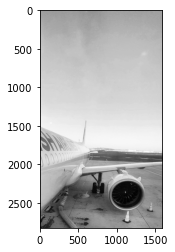

In [620]:
# global variables and settings
torch.no_grad()
img_path = 'imgs/airplane.jpg'

# preprocessor
prep = transforms.Compose([transforms.ToTensor()])

# read image
img = prep(Image.open(img_path)).unsqueeze(0)
plt.imshow(1 - img.squeeze()[0], cmap='Greys')
plt.show()

In [621]:
# sobel kernel
kernel = torch.tensor(
    [[-1.0, 0, 1.0],
    [-2.0, 0, 2.0],
    [-1.0, 0, 1.0]])
kernel = kernel.unsqueeze(0)
kernel = torch.cat([kernel, kernel, kernel], dim=0)
kernel = kernel.unsqueeze(0)

# convolve kernel with image
output1 = F.conv2d(img, kernel, padding=1)
output2 = F.conv2d(img, torch.transpose(kernel, dim0=2, dim1=3), padding=1)
output = torch.sqrt(output1**2 + output2**2)
theta_map = torch.atan2(output2, output1).squeeze()

output = output.squeeze()
output -= torch.min(output)
output /= torch.max(output)

def clip(input):
    if input < 0.2:
        return 0
    else:
        return 1

output = output.apply_(clip)
output[:, -1] = 0
output[-1, :] = 0
output[:, 0] = 0
output[0, :] = 0

plt.imshow(1 - output, cmap='Greys')
plt.show()

KeyboardInterrupt: 

In [601]:
# Perform polar hough transform
theta_increment = .01

d_range = int(math.sqrt(output.shape[0]**2 + output.shape[1]**2))
theta_range = int(math.pi / theta_increment) + 1
hough_space = np.zeros([theta_range, d_range])

for y, row in enumerate(output):
    for x, pixel in enumerate(row):
        if pixel == 1:
            theta = theta_map[y][x]
            
            while theta > math.pi:
                theta -= math.pi

            while theta < 0:
                theta += math.pi

            d = x * math.cos(theta) + y * math.sin(theta)
            hough_space[int(theta / theta_increment)][int(d)] += 1


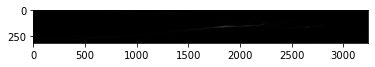

In [602]:
# before smoothing hough space
plt.imshow(1 - hough_space, cmap='Greys')
plt.show()

In [612]:
# smooth hough space
smoothing_kernel = torch.tensor([[1, 2, 1], [2, 8, 2], [1, 2, 1]]).unsqueeze(0).unsqueeze(0).double()
hough_space = F.conv2d(torch.from_numpy(hough_space).unsqueeze(0).unsqueeze(0), smoothing_kernel, padding=1)
hough_space.squeeze()

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0222,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0056,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

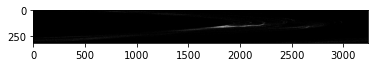

In [613]:
# continue smooth hough space
hough_space2 = hough_space.squeeze()
hough_space2 /= torch.max(hough_space2)
hough_space2 = hough_space2.numpy()
plt.imshow(1 - hough_space2, cmap='Greys')
plt.show()
hough_space = hough_space2

In [623]:
# create lines back in linear space
chosen_points = []
for i in range(50):
    index = np.unravel_index(np.argmax(hough_space, axis=None), hough_space.shape)
    hough_space[index] = 0

    chosen_points.append(index)

m_b_values = []
for theta_values, d_values in chosen_points:
    if theta_values != 0:
        theta = theta_values * theta_increment
        m_b_values.append([-1/math.tan(theta), d_values/math.sin(theta)])
    else:
        m_b_values.append([math.inf, math.inf])

In [568]:
# print(chosen_points)
# print(m_b_values)

[(162, 1853), (149, 1868), (151, 1857), (150, 2067), (160, 1926), (149, 2075), (150, 1862), (150, 2069), (151, 1856), (160, 1869), (161, 1859), (162, 1847), (149, 2076), (149, 2077), (150, 1863), (150, 2070), (151, 2060), (157, 1824), (160, 1920), (161, 1914), (148, 1874), (149, 2071), (149, 2072), (151, 1858), (156, 1826), (159, 1881), (159, 1886), (159, 1930), (160, 1875), (160, 1919), (147, 1882), (147, 2156), (148, 2084), (149, 1869), (150, 1860), (150, 2064), (151, 2050), (151, 2061), (152, 1851), (153, 1844), (158, 1946), (159, 1880), (159, 1888), (160, 1921), (161, 1862), (162, 1854), (162, 1856), (162, 1857), (148, 1877), (148, 2146), (150, 2063), (151, 1852), (152, 2054), (153, 1839), (153, 1840), (155, 1826), (157, 1825), (158, 1893), (161, 1911), (162, 1844), (162, 1904), (144, 2184), (144, 2185), (145, 2178), (146, 2162), (147, 1880), (150, 1864), (150, 2066), (151, 2051), (151, 2056), (153, 1843), (153, 2026), (154, 1830), (155, 1829), (159, 1799), (159, 1934), (160, 1797)

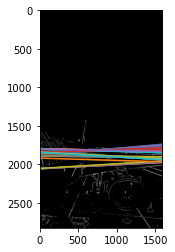

In [615]:
# plot things
plt.imshow(1 - output.squeeze(), cmap='Greys')

plt.xlim(0, output.shape[1])
plt.ylim(output.shape[0], 0)

for i, coeff in enumerate(m_b_values):
    if coeff[0] == math.inf:
        x = np.ones([100]) * chosen_points[i][1]
        y = np.linspace(0, output.shape[0], 100)
    else:
        x = np.linspace(0, output.shape[1], 100)
        y = coeff[0] * x + coeff[1]
    
    plt.plot(x, y)

plt.show()